In [86]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import lightgbm as lgb
from sklearn.model_selection import KFold
import time
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# Read The Training Data

In [87]:
df_raw = pd.read_csv('/Users/liaopeng3/logs/google_analytics_all/extracted_fields_train.gz', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
df_test_raw = pd.read_csv('/Users/liaopeng3/logs/google_analytics_all/extracted_fields_test.gz', 
                   dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
df_raw.shape, df_test_raw.shape

((903653, 30), (804684, 30))

# Read the Test Data

In [88]:
df_train = df_raw.copy()

In [89]:
df_train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [90]:
df_test_tmp = df_train.drop_duplicates('fullVisitorId')

In [91]:
df_test_tmp_join = df_test_tmp.merge(df_test_raw,on='fullVisitorId',how='inner')

In [92]:
df_test_tmp_join.shape

(20284, 59)

# EDA 1

In [93]:
# df_train.loc[df_train['fullVisitorId']=='1957458976293878100'].to_csv('sample_1957458976293878100.csv',index=False)

In [94]:
# df_train.groupby('fullVisitorId').count().sort_values('channelGrouping',ascending=False).head(10)
df_train.fullVisitorId.value_counts().head()

1957458976293878100    278
0824839726118485274    255
3608475193341679870    201
1856749147915772585    199
3269834865385146569    155
Name: fullVisitorId, dtype: int64

In [95]:
df_tmp_customer = df_train[df_train.fullVisitorId=='1957458976293878100']

In [96]:
df_tmp_customer.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
921,Organic Search,20160902,1957458976293878100,1957458976293878100_1472841771,1.472842e+09,85.0,1.472842e+09,Firefox,desktop,0.0,...,NaN,16.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google
1645,Organic Search,20160902,1957458976293878100,1957458976293878100_1472821703,1.472822e+09,83.0,1.472822e+09,Firefox,desktop,0.0,...,NaN,3.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google
1666,Organic Search,20160902,1957458976293878100,1957458976293878100_1472823804,1.472824e+09,84.0,1.472824e+09,Firefox,desktop,0.0,...,NaN,5.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google
4366,Organic Search,20170126,1957458976293878100,1957458976293878100_1485444781,1.485445e+09,178.0,1.485445e+09,Firefox,desktop,0.0,...,NaN,3.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google
6602,Display,20170623,1957458976293878100,1957458976293878100_1498248064,1.498248e+09,309.0,1.498248e+09,Firefox,desktop,0.0,...,NaN,11.0,NaN,NaN,(not set),1.0,NaN,cpm,NaN,dfa


In [97]:
df_tmp_customer['date']=df_tmp_customer['date'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d') )

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
cnt_srs.head()

,sum
date,
2016-08-04,4.0
2016-08-05,2.0
2016-08-06,0.0
2016-08-07,0.0
2016-08-08,0.0


In [99]:
# cnt_srs['sum'].value_counts()

In [100]:
df_tmp_customer['date'].max(),df_tmp_customer['date'].min()

(Timestamp('2017-08-01 00:00:00'), Timestamp('2016-08-04 00:00:00'))

In [101]:
df_tmp_customer.date.nunique()

145

In [102]:
df_tmp_customer.shape

(278, 30)

In [57]:
tmp_dt_range= pd.DataFrame({'date':pd.date_range(start='2016-08-04 00:00:00', end='2017-08-01 00:00:00')}) 

In [58]:
df_tmp_customer = tmp_dt_range.merge(df_tmp_customer,on='date',how='left')

In [59]:
df_tmp_customer.date.nunique()

363

In [60]:
df_tmp_customer.head()

,date,channelGrouping,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,2016-08-04,Organic Search,1957458976293878100,1957458976293878100_1470328437,1.470328e+09,38.0,1.470328e+09,Firefox,desktop,0.0,...,NaN,4.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,2016-08-05,Organic Search,1957458976293878100,1957458976293878100_1470419668,1.470420e+09,39.0,1.470420e+09,Firefox,desktop,0.0,...,NaN,2.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google
2,2016-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
df_tmp_customer['totals.pageviews'].isnull().sum()

0

In [65]:
df_tmp_customer['totals.pageviews'].fillna(0,inplace=True)

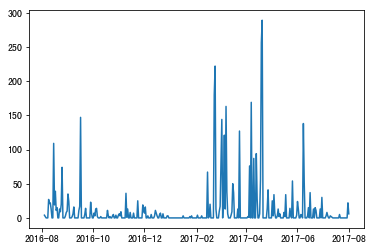

In [84]:
cnt_srs = df_tmp_customer.groupby('date')['totals.pageviews'].agg(['sum'])
cnt_srs = cnt_srs.sort_index()

plt.plot(cnt_srs.index, cnt_srs['sum'])

# Concatenate the Training and Test Dat

In [9]:
df_train.columns.difference(df_test_raw.columns)

Index([], dtype='object')

In [10]:
df_test_raw.columns.difference(df_train.columns)

Index([], dtype='object')

In [24]:
df3 = pd.concat([df_train.drop(['totals.transactionRevenue'],axis=1),df_test_raw],ignore_index=True) 

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [25]:
df_train.shape

(903653, 30)

In [26]:
len_df_train = df_train.shape[0]

# Split Feature and Label Data

In [27]:
train_y = df_train['totals.transactionRevenue'].fillna(0).astype(float).apply(lambda x: np.log1p(x))

# Add Visit Time

In [28]:
df3['diff_visitId_time'] = df3['visitId'] - df3['visitStartTime']
df3['diff_visitId_time'] = (df3['diff_visitId_time'] != 0).astype(int)

# Format the Numerous Variables

In [29]:
list_v = ['totals.hits','totals.pageviews']

In [30]:
for cols in list_v:
    df3[cols]=df3[cols].astype(float)

##  Drop the Constant Columns

In [31]:
cols_drop = []
for cols in df3.columns:
    if df3[cols].nunique()==1:
#         print(cols)
        cols_drop.append(cols)
        
df3 = df3.drop(cols_drop,axis=1)

# Convert Date to Numeric Variables

In [32]:
df3.head()

,channelGrouping,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,geoNetwork.country,...,trafficSource.adContent,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime,diff_visitId_time
0,Organic Search,20160902,Chrome,desktop,0.0,Windows,1131660440785968503,Izmir,Asia,Turkey,...,NaN,(not set),(not provided),organic,NaN,google,1.472830e+09,1.0,1.472830e+09,0
1,Organic Search,20160902,Firefox,desktop,0.0,Macintosh,377306020877927890,not available in demo dataset,Oceania,Australia,...,NaN,(not set),(not provided),organic,NaN,google,1.472880e+09,1.0,1.472880e+09,0
2,Organic Search,20160902,Chrome,desktop,0.0,Windows,3895546263509774583,Madrid,Europe,Spain,...,NaN,(not set),(not provided),organic,NaN,google,1.472865e+09,1.0,1.472865e+09,0
3,Organic Search,20160902,UC Browser,desktop,0.0,Linux,4763447161404445595,not available in demo dataset,Asia,Indonesia,...,NaN,(not set),google + online,organic,NaN,google,1.472881e+09,1.0,1.472881e+09,0
4,Organic Search,20160902,Chrome,mobile,1.0,Android,27294437909732085,not available in demo dataset,Europe,United Kingdom,...,NaN,(not set),(not provided),organic,NaN,google,1.472823e+09,2.0,1.472823e+09,0


In [33]:
format_str = '%Y%m%d' 
df3['date'] = df3['date'].apply(lambda x: datetime.strptime(str(x), format_str))

In [34]:
df3['date_dayofweek'] = df3['date'].dt.dayofweek
df3['date_year'] = df3['date'].dt.year

df3['date_hour'] = df3['date'].dt.hour

df3['date_month'] = df3['date'].dt.month
df3['date_day'] = df3['date'].dt.day

df3['date_month'] = df3['date'].apply(lambda x:x.month)
df3['date_quarter_month'] = df3['date'].apply(lambda x:x.day//8)
df3['date_weekday'] = df3['date'].apply(lambda x:x.weekday())


In [29]:
df3 = df3.drop('date',axis=1)

# EDA 3

In [64]:
df_eda_tmp_test = df3.loc[df_train.shape[0]:]

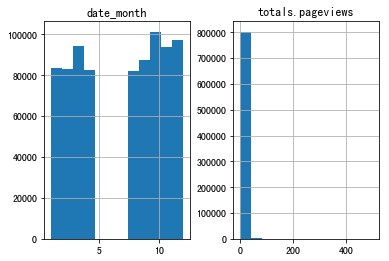

In [65]:
hist = df_eda_tmp_test[['date_month','totals.pageviews']].hist(bins=12)

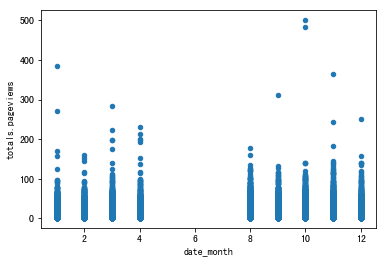

In [66]:
ax1 = df_eda_tmp_test.plot.scatter(x='date_month',y='totals.pageviews')

In [75]:
df_sns_tmp = df_eda_tmp_test.groupby('date2')['totals.pageviews'].agg('sum').reset_index()

In [78]:
df_sns_tmp.head()

,date2,totals.pageviews
0,2017-08-02,11631.0
1,2017-08-03,10996.0
2,2017-08-04,12487.0
3,2017-08-05,7065.0
4,2017-08-06,9243.0


/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



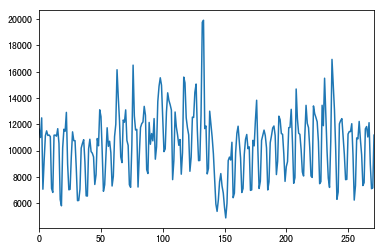

In [80]:
sns.tsplot(data = df_sns_tmp['totals.pageviews'], time = df_sns_tmp['date2'] )

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



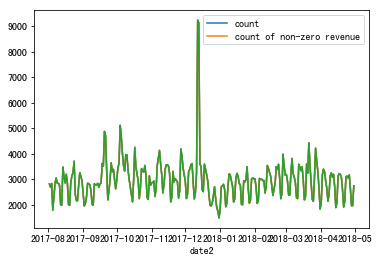

In [70]:
df_eda_tmp_test['date2'] = df_eda_tmp_test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[5:7]), int(str(x)[8:10])))
cnt_srs = df_eda_tmp_test.groupby('date2')['totals.pageviews'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()

# cnt_srs = df_eda_tmp.groupby('date2')['totals.transactionRevenue'].agg(['size', 'count'])
# data.time = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S.%f')
# df_eda_tmp.set_index(['date'],inplace=True)
cnt_srs.plot()

#OR 
plt.plot(cnt_srs.index, cnt_srs['count'])
# plt.plot(cnt_srs.index, cnt_srs['count'])

# EDA 2

In [35]:
df_eda_tmp = df3.loc[0:df_train.shape[0]]

In [36]:
df_eda_tmp['rev']=train_y

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


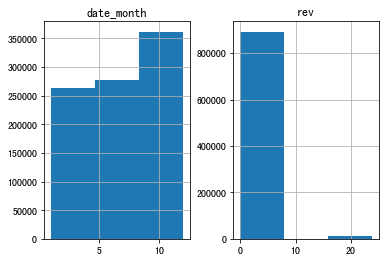

In [37]:
hist = df_eda_tmp[['date_month','rev']].hist(bins=3)

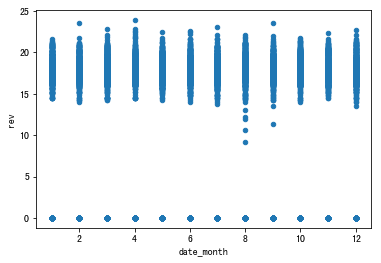

In [38]:
ax1 = df_eda_tmp.plot.scatter(x='date_month',y='rev')

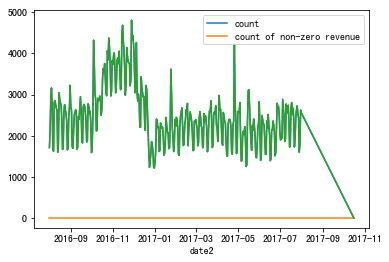

In [63]:
df_eda_tmp['date2'] = df_eda_tmp['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[5:7]), int(str(x)[8:10])))
cnt_srs = df_eda_tmp.groupby('date2')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()

# cnt_srs = df_eda_tmp.groupby('date2')['totals.transactionRevenue'].agg(['size', 'count'])
# data.time = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S.%f')
# df_eda_tmp.set_index(['date'],inplace=True)
cnt_srs.plot()

#OR 
plt.plot(cnt_srs.index, cnt_srs['count'])

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



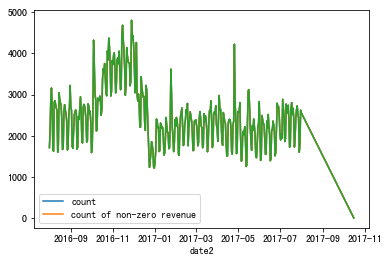

In [71]:
df_eda_tmp['date2'] = df_eda_tmp['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[5:7]), int(str(x)[8:10])))
cnt_srs = df_eda_tmp.groupby('date2')['totals.pageviews'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()

# cnt_srs = df_eda_tmp.groupby('date2')['totals.transactionRevenue'].agg(['size', 'count'])
# data.time = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S.%f')
# df_eda_tmp.set_index(['date'],inplace=True)
cnt_srs.plot()

#OR 
plt.plot(cnt_srs.index, cnt_srs['count'])

# Visit Time

In [81]:
df3['visitStartTime'] = df3['visitStartTime'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))

# df3['visitStartTime'] = pd.to_datetime(df3['visitStartTime'],unit='s')

In [82]:
df3['visitStartTime'] = pd.to_datetime(df3['visitStartTime'])

df3['quarter_month'] = df3['visitStartTime'].apply(lambda x:x.day//8)

# df3.loc[1020:1025,['visitStartTime','quarter_month']]

df3['quarter_month'].value_counts()

df3['day_month'] = df3['visitStartTime'].apply(lambda x:x.day)


# df3['day_month'].value_counts()

df3['WoY'] = df3['visitStartTime'].apply(lambda x: x.isocalendar()[1])

# df3['WoY'].value_counts()

df3['visit_dayofweek'] = df3['visitStartTime'].dt.dayofweek
df3['visit_year'] = df3['visitStartTime'].dt.year

df3['visit_month'] = df3['visitStartTime'].dt.month
df3['visit_day'] = df3['visitStartTime'].dt.day
df3['visit_hour'] = df3['visitStartTime'].dt.hour



In [83]:
# df['vis_date'] = pd.to_datetime(df['visitStartTime'], unit='s')
# df['sess_date_dow'] = df['vis_date'].dt.dayofweek
# df['sess_date_hours'] = df['vis_date'].dt.hour
# df['sess_date_dom'] = df['vis_date'].dt.day
# df.sort_values(['fullVisitorId', 'vis_date'], ascending=True, inplace=True)
df3['next_session_1'] = (df3['visitStartTime'] - df3[['fullVisitorId', 'visitStartTime']].groupby('fullVisitorId')['visitStartTime']\
                         .shift(1)).astype(np.int64) // 1e9 // 60 // 60
df3['next_session_2'] = (df3['visitStartTime'] - df3[['fullVisitorId', 'visitStartTime']].groupby('fullVisitorId')['visitStartTime']\
                         .shift(-1)).astype(np.int64) // 1e9 // 60 // 60

df3['nb_pageviews'] = df3['date'].map(
    df3[['date', 'totals.pageviews']].groupby('date')['totals.pageviews'].sum()
)

df3['ratio_pageviews'] = df3['totals.pageviews'] / df3['nb_pageviews']

In [32]:
df3 = df3.drop('visitStartTime',axis=1)

In [34]:
df3.loc[df3['fullVisitorId']=='1957458976293878100'].to_csv('sample_1957458976293878100.csv',index=False)

# Convert the Object Values to Numeric

In [21]:
for cols in df3.columns:
    if df3[cols].dtypes == object or df3[cols].dtypes== bool:
#         df3[cols] = df3[cols].astype('category')
#         df3["new_"+cols] = df3[cols].cat.codes
        df3["new_"+cols] = pd.factorize( df3[cols])[0]
        df3 = df3.drop(cols,axis=1)
        df3 = df3.rename(columns={"new_"+cols:cols})

# Clean the Data Again

##  Drop the Constant Columns

In [29]:
cols_drop = []
for cols in df3.columns:
    if df3[cols].nunique()==1:
#         print(cols)
        cols_drop.append(cols)
        
df3 = df3.drop(cols_drop,axis=1)

# Baseline Model

# Split Feature and Label Data

In [37]:
train_x = df3[:len_df_train]


In [38]:
test_x = df3[len_df_train:]

# Training Model

In [39]:

# regr = RandomForestRegressor(max_depth=2, random_state=0,
#                              n_estimators=100)


# def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
#     predictions = model.predict(X_train)
#     mse = mean_squared_error(y_train, predictions)
#     rmse = np.sqrt(mse)
#     return rmse



# import numpy as np

# # calc_train_error(train_x, train_y, model)

In [40]:
param = {'num_leaves': 300,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         'boosting_type' : 'gbdt',
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 1,
         "verbosity": -1}

In [41]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_x))
predictions = np.zeros(len(test_x))
start = time.time()
features = list(train_x.columns)
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_x.values, train_y.values)):
    trn_data = lgb.Dataset(train_x.iloc[trn_idx].values, label=train_y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train_x.iloc[val_idx].values, label=train_y.iloc[val_idx].values)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_x.iloc[val_idx].values, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_x.values, num_iteration=clf.best_iteration) / folds.n_splits

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.74471	valid_1's rmse: 1.76396
[200]	training's rmse: 1.60054	valid_1's rmse: 1.6673
[300]	training's rmse: 1.51325	valid_1's rmse: 1.62449
[400]	training's rmse: 1.45353	valid_1's rmse: 1.60454
[500]	training's rmse: 1.40704	valid_1's rmse: 1.59444
[600]	training's rmse: 1.36859	valid_1's rmse: 1.58911
[700]	training's rmse: 1.33562	valid_1's rmse: 1.586
[800]	training's rmse: 1.30596	valid_1's rmse: 1.58402
[900]	training's rmse: 1.28018	valid_1's rmse: 1.58301
[1000]	training's rmse: 1.25701	valid_1's rmse: 1.58263
[1100]	training's rmse: 1.23538	valid_1's rmse: 1.58224
[1200]	training's rmse: 1.21561	valid_1's rmse: 1.58202
Early stopping, best iteration is:
[1193]	training's rmse: 1.21691	valid_1's rmse: 1.58198
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.7466	valid_1's rmse: 1.75681
[200]	training's rmse: 1.60193	valid_1's rmse: 1.66363
[300]	training

In [42]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof, train_y)**0.5))

CV score: 1.59125 


In [43]:
# GBDT: CV score: 1.61400, 
# RF: CV score: 1.64722, 
# DART: CV score: 1.63164 

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


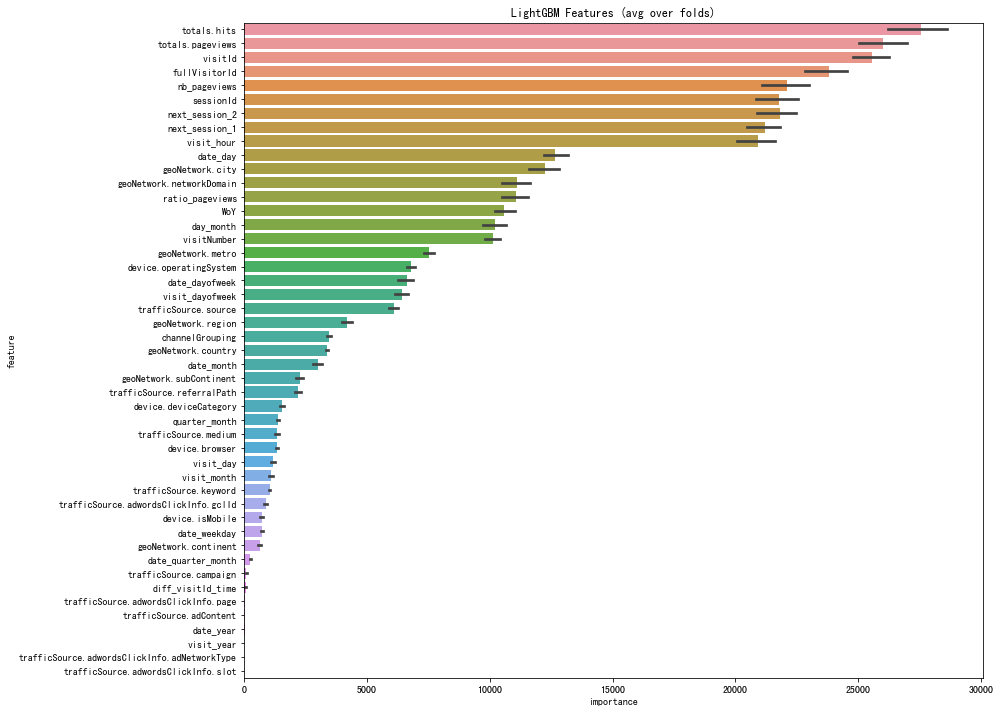

In [44]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:1000].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [45]:
submission = df_test_raw[['fullVisitorId']].copy()

submission.loc[:, 'PredictedLogRevenue'] = predictions
submission.loc[:, 'PredictedLogRevenue'] = np.expm1(predictions)
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test["PredictedLogRevenue"] = np.log1p(grouped_test["PredictedLogRevenue"])
grouped_test["PredictedLogRevenue"] =  grouped_test["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
grouped_test['fullVisitorId']=grouped_test['fullVisitorId'].astype('str')
grouped_test.to_csv('mySubmit1018_gbdt.csv',index=False)